## Exploratory analysis

In [ ]:
import nltk 
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
## install necessary packages 
!pip install rouge_score
! pip install datasets
!pip install transformers 
!pip install contractions 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=023e8bb93386c8533afa1d6ded277176ac35e09eea777a11ae959d84dc7391bc
  Stored in directory: /root/.cache/pip/wheels/24/55/6f/ebfc4cb176d1c9665da4e306e1705496206d08215c1acd9dde
Successfully built rouge_score
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 7.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing install

In [ ]:
## import data packages 
import pandas as pd 
import re 
from random import randint
import string
import unicodedata
from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud
import numpy as np 
from datasets import load_dataset
from contractions import contractions_dict
import torch 
from datasets import Dataset, load_metric

## Visualization 
import matplotlib.pyplot as plt 
import seaborn as sns 
## models & tokenization
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer



We connect with Google drive drive to save our models.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


Read the data

In [ ]:
## read the input data 
df = pd.read_json("AgrSmall.json")
df.head()

,doi,titles,abstracts,authors,keywords,sources
0,10.3390,Community Faecal Management Strategies and Per...,Most people in rural areas in South Africa (SA...,"[Matthew Mamera, Johan J. van Tol, Makhosazana...",agriculture,mdpi
1,10.3390,Adoption of Sustainable Agriculture Practices ...,The aim of this study was to highlight the imp...,"[Rafay Waseem, Gershom Endelani Mwalupaso, Far...",agriculture,mdpi
2,10.3390,Atlanta Residents’ Knowledge Regarding Heavy M...,Urban agriculture and gardening provide many h...,"[Lauren Balotin, Samantha Distler, Antoinette ...",agriculture,mdpi
3,10.3390,Perceptions of the Challenges and Opportunitie...,Waste management has become pertinent in urban...,"[Nqubeko Neville Menyuka, Melusi Sibanda, Urmi...",agriculture,mdpi
4,10.3390,An Assessment of Seaweed Extracts: Innovation ...,Plant growth regulators (PGRs) are described i...,"[El Chami Daniel, Galli Fabio]",agriculture,mdpi


Using contractions in treating data in NLP cases is important for accurate representation of the meaning of the text and for standardization of the data.

In [ ]:
for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


In [ ]:
def expand_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


expand_contractions("y'all can't expand contractions i'd think")

'you all cannot expand contractions id think'

Converting text to lowercase before applying NLP models is a common technique used to standardize text and reduce the dimensionality of the input data.

In [ ]:
df= df[['titles',"abstracts"]]
# Converting to lowercase
df.titles = df.titles.apply(str.lower)
df.abstracts = df.abstracts.apply(str.lower)
df.head()

,titles,abstracts
0,community faecal management strategies and per...,most people in rural areas in south africa (sa...
1,adoption of sustainable agriculture practices ...,the aim of this study was to highlight the imp...
2,atlanta residents’ knowledge regarding heavy m...,urban agriculture and gardening provide many h...
3,perceptions of the challenges and opportunitie...,waste management has become pertinent in urban...
4,an assessment of seaweed extracts: innovation ...,plant growth regulators (pgrs) are described i...


In [ ]:
## apply the expand_contractions function on both the titles and the abstracs columns 
df.titles = df.titles.apply(expand_contractions)
df.abstracts = df.abstracts.apply(expand_contractions)
df.head()

,titles,abstracts
0,community faecal management strategies and per...,most people in rural areas in south africa (sa...
1,adoption of sustainable agriculture practices ...,the aim of this study was to highlight the imp...
2,atlanta residents’ knowledge regarding heavy m...,urban agriculture and gardening provide many h...
3,perceptions of the challenges and opportunitie...,waste management has become pertinent in urban...
4,an assessment of seaweed extracts: intion for ...,plant growth regulators (pgrs) are described i...


Punctuation marks such as commas, periods, and question marks may not provide any useful information for certain NLP tasks. In fact, they may introduce noise into the data and affect the accuracy of some models. It also helps to normalize the text and reduce the number of distinct tokens that need to be processed.

In [ ]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

print(rm_punc_from_word('#cool!'))

# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

print(rm_punc_from_text("Frankly, my dear, I don't give a damn"))

cool
Frankly my dear I dont give a damn


In [ ]:
# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

print(rm_number_from_text('You are 100times more sexier than me'))
print(rm_number_from_text('If you taught yes then you are 10 times more delusional than me'))

You are times more sexier than me
If you taught yes then you are times more delusional than me


Stop words refer to a set of commonly used words that are often removed from text because they are considered to be uninformative or irrelevant for certain NLP tasks. Stop words include words such as "the", "a", "an", "and", "of", "to", "in", and so on. The idea behind removing stop words is to reduce the dimensionality of the input data and improve the efficiency and accuracy of certain NLP tasks.

In [ ]:
# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

rm_stopwords_from_text("Love means never having to say you're sorry")

'Love means never say sorry'

In [ ]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

clean_text("Mrs. Robinson, you're trying to seduce me, aren't you?")

'mrs robinson youre trying seduce arent'

In [ ]:
## apply clean_text 
df.titles = df.titles.apply(clean_text)
df.abstracts = df.abstracts.apply(clean_text)
df.head()

,titles,abstracts
0,community faecal management strategies percept...,people rural areas south africa sa rely untrea...
1,adoption sustainable agriculture practices ban...,aim study highlight importance socioeconomic p...
2,atlanta residents knowledge regarding heavy me...,urban agriculture gardening provide many healt...
3,perceptions challenges opportunities utilising...,waste management become pertinent urban region...
4,assessment seaweed extracts intion sustainable...,plant growth regulators pgrs described literat...


In [ ]:
# To customize colours of wordcloud texts
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)


# stopwords for wordcloud
def get_wc_stopwords():
    wc_stopwords = set(STOPWORDS)

    # Adding words to stopwords
    # these words showed up while plotting wordcloud for text
    wc_stopwords.add('s')
    wc_stopwords.add('one')
    wc_stopwords.add('using')
    wc_stopwords.add('example')
    wc_stopwords.add('work')
    wc_stopwords.add('use')
    wc_stopwords.add('make')

    return wc_stopwords


# plot wordcloud
def plot_wordcloud(text, color_func):
    wc_stopwords = get_wc_stopwords()
    wc = WordCloud(stopwords=wc_stopwords, width=1200, height=600, random_state=0).generate(text)

    f, axs = plt.subplots(figsize=(20, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.xlabel('WordCloud')

The Wordcloud plots represent the frequency of words in a text corpus. They are useful for gaining insights into the key themes and topics present in a set of documents.

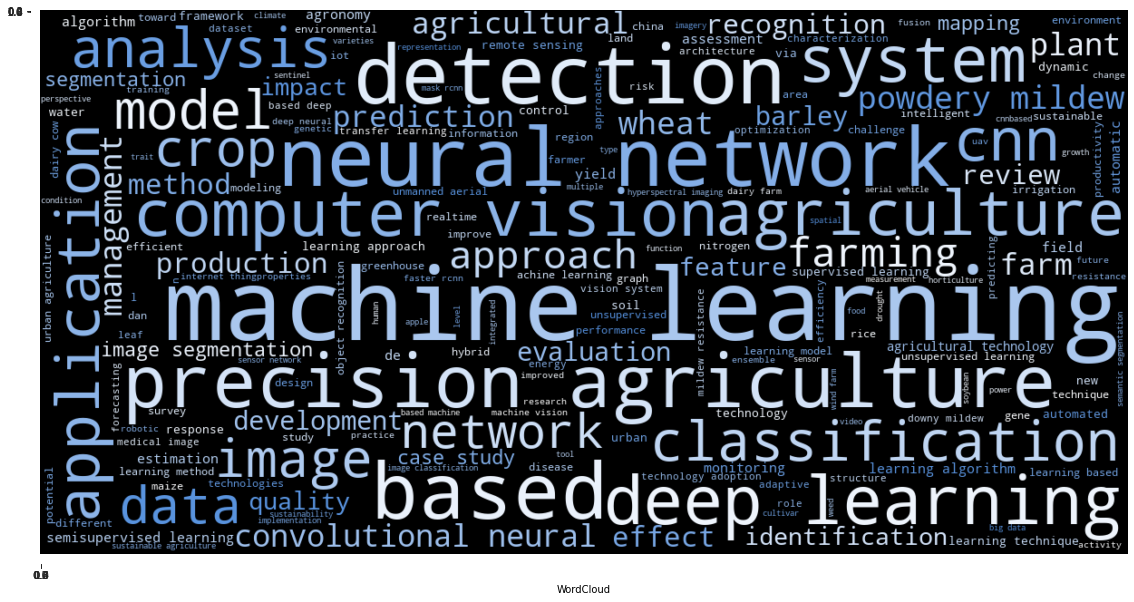

In [ ]:
plot_wordcloud(' '.join(df.titles.values.tolist()), wc_blue_color_func)

As we can see, the tiltes sentences display some words with high frequency: machine, learning, based, precision, classification, neural, network. We can understand  that many abstracts are about IA and Machine Learning. 

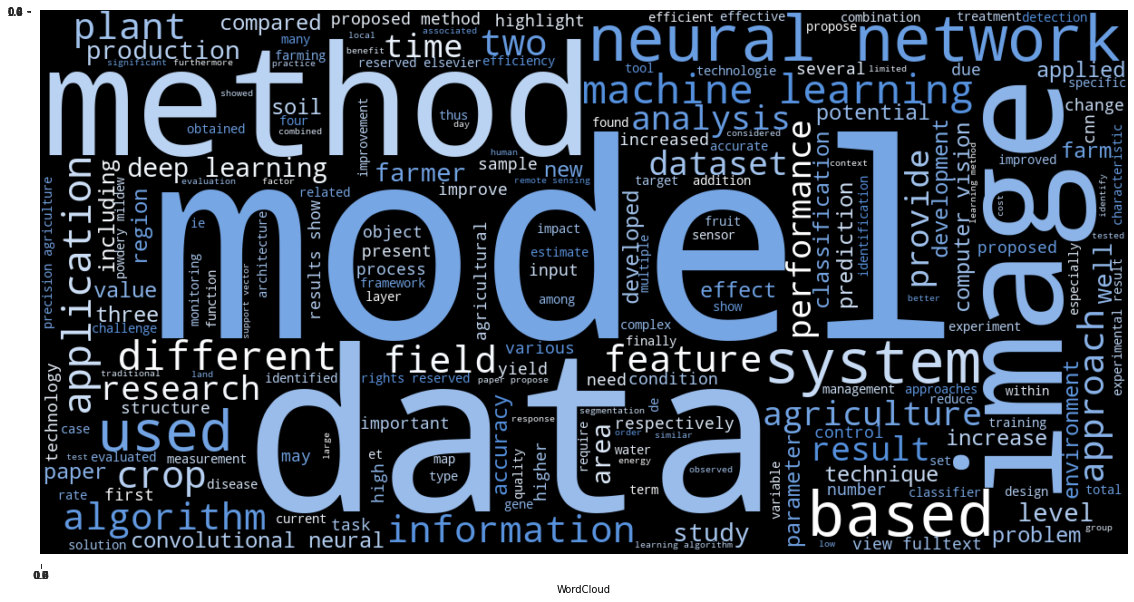

In [ ]:
plot_wordcloud(' '.join(df.abstracts.values.tolist()), wc_blue_color_func)

As we can see, the abstracts sentences display some words with high frequency: model, data, neural, network, algorithm. Again, we can make the same conclusion.

Plot the distribution of words contained in each titles, and in each abstract and in each title.

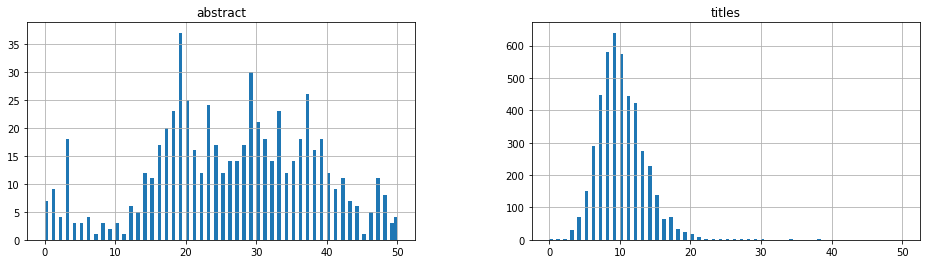

In [ ]:
text_count = [len(sentence.split()) for sentence in df.abstracts]
headlines_count = [len(sentence.split()) for sentence in df.titles]

pd.DataFrame({'abstract': text_count, 'titles': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

## Fine tune model t5-model 

Extractive summarization is the task of generating a summary of a long document by selecting and condensing its most important sentences or phrases. With the rise of digital content, the demand for automated summarization systems has increased significantly. One of the popular methods for extractive summarization is using a pre-trained transformer-based model and fine-tuning it on a target dataset.

In this project, we fine-tuned a T5 model on the XSum dataset for extractive summarization. The XSum dataset is a large-scale collection of news articles accompanied by human-written summaries. The T5 model is a pre-trained transformer-based model that has been trained on a large and diverse collection of text data using unsupervised learning. By fine-tuning the T5 model on the XSum dataset, we aimed to build a model that could generate high-quality summaries for news articles.

The XSUM dataset was created by researchers at the University of Edinburgh and is intended for use in the development of text summarization systems. The dataset contains over 200,000 news articles from a diverse set of sources, such as BBC News, CNN, and The New York Times, among others.

We followed a standard approach for fine-tuning the T5 model on the XSum dataset. The approach involved the following steps:

- Data Preprocessing.

- Fine-tuning the T5 Model: We fine-tuned the T5 model on the XSum training set using the Hugging Face transformers library. We used a sequence-to-sequence (seq2seq) architecture with a maximum input length of 512 tokens and a maximum output length of 200 tokens. The model was trained using the Adam optimizer with a learning rate of 2e-5 for 10 epochs.

- Evaluation: We evaluated the performance of the fine-tuned T5 model on the XSum validation and test sets using the ROUGE metric. The ROUGE metric is commonly used for evaluating the quality of text summarization models.

In [ ]:
## load the Xsum dataset to fine tune the t5 model 
raw_datasets = load_dataset("xsum", split="train")
training_data = pd.DataFrame(raw_datasets)

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Dataset xsum downloaded and prepared to /root/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71. Subsequent calls will reuse this data.


In [ ]:
training_data.head()

,document,summary,id
0,"The full cost of damage in Newton Stewart, one...",Clean-up operations are continuing across the ...,35232142
1,A fire alarm went off at the Holiday Inn in Ho...,Two tourist buses have been destroyed by fire ...,40143035
2,Ferrari appeared in a position to challenge un...,Lewis Hamilton stormed to pole position at the...,35951548
3,"John Edward Bates, formerly of Spalding, Linco...",A former Lincolnshire Police officer carried o...,36266422
4,Patients and staff were evacuated from Cerahpa...,An armed man who locked himself into a room at...,38826984


In [ ]:
# pad texts to the same length 

def preprocess_test(examples):

  inputs = [prefix + text for text in examples['text']]

  model_inputs = tokenizer(inputs, max_length= max_input_length, truncation=True,
                           padding="max_length")
  
  return model_inputs 

In [ ]:
## To fine train we will use only the first 1000 rows
training_data_s = training_data[:1000]

In [ ]:
## using t5 model for the task of summarization 
model_name = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
## define preprocess function to tokenize training data
def preprocess_function(examples):
    inputs = examples['document']
    targets = examples['summary']
    model_inputs = tokenizer(inputs, max_length=512, padding="max_length", truncation=True)
    with tokenizer.as_target_tokenizer():
        targets_tokens = tokenizer(targets, max_length=64, padding="max_length", truncation=True)
    model_inputs["labels"] = targets_tokens["input_ids"]
    return model_inputs


In [ ]:
## split data into training and validation 
from sklearn.model_selection import train_test_split
training , validation = train_test_split( training_data_s, test_size = 0.2)

In [ ]:
## Parameters to fine tune the model
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,  ## fine tune with a number of 10 epochs 
    weight_decay=0.01,
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=500,
    logging_strategy="epoch",
    save_strategy='epoch',
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)


In [ ]:
## preprocess training data
train_dataset = Dataset.from_pandas(training)
train_dataset = train_dataset.map(preprocess_function, batched=True)
## preprocess validation data
val_dataset = Dataset.from_pandas(validation)
val_dataset = val_dataset.map(preprocess_function, batched=True)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer, 
    model=model, 
    padding=True,
    max_length=512,
    label_pad_token_id=-100
)

  0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3581: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
val_dataset['document'][0]

'The 26-year-old Brazil international has signed a five-year deal and will join City on their pre-season tour of the United States.\nDanilo can play in both full-back roles as well as in midfield, and is City\'s fourth major signing of the summer.\n"There was interest from other clubs, but it has always been my ambition to play for Pep Guardiola," he said.\nHis arrival takes City\'s summer spending to almost £150m, following the recruitment of England international Kyle Walker (£45m), Portugal midfielder Bernardo Silva (£43m) and Brazilian goalkeeper Ederson Moraes (£35m).\nThe club have also agreed a £52m deal for 23-year-old Monaco defender Benjamin Mendy and sold left-back Aleksandar Kolarov to Serie A club Roma for £4.5m.\nDanilo\'s move is subject to him receiving a work permit, meaning he is unlikely to make his debut when City face Real on Wednesday in Los Angeles.\nThe former Santos player joined Real in 2015 from Porto but started just 17 La Liga games last season.\nIn two yea

In [ ]:
## run trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer
)
# Fine-tune the model
trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: document, id, __index_level_0__, summary. If document, id, __index_level_0__, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 800
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1000
  Number of trainable parameters = 222903552
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.

Epoch,Training Loss,Validation Loss
1,1.050500,1.065388
2,0.961900,1.058712
3,0.994400,1.048136
4,0.972900,1.042788
5,0.949100,1.041152
6,0.932500,1.039497
7,0.912000,1.039953
8,0.900200,1.040479
9,0.895600,1.040069
10,0.891400,1.040204


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: document, id, __index_level_0__, summary. If document, id, __index_level_0__, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Configuration saved in ./results/checkpoint-100/generation_config.json
tokenizer config file saved in ./results/checkpoint-100/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-100/special_tokens_map.json
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2357: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
The following column

TrainOutput(global_step=1000, training_loss=0.9460434494018555, metrics={'train_runtime': 1299.2817, 'train_samples_per_second': 6.157, 'train_steps_per_second': 0.77, 'total_flos': 4871663124480000.0, 'train_loss': 0.9460434494018555, 'epoch': 10.0})

In [ ]:
model.to('cpu')

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

### Test on example

In [ ]:
test  = df[['titles' , 'abstracts']]
test.columns = ['summary','document']
test.head()

,summary,document
0,community faecal management strategies percept...,people rural areas south africa sa rely untrea...
1,adoption sustainable agriculture practices ban...,aim study highlight importance socioeconomic p...
2,atlanta residents knowledge regarding heavy me...,urban agriculture gardening provide many healt...
3,perceptions challenges opportunities utilising...,waste management become pertinent urban region...
4,assessment seaweed extracts intion sustainable...,plant growth regulators pgrs described literat...


In [ ]:
test_dataset = Dataset.from_pandas(test)
test_dataset = test_dataset.map(preprocess_function, batched=True)


  0%|          | 0/5 [00:00<?, ?ba/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3581: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
input_text = test_dataset['document'][0]
inputs = tokenizer(input_text, return_tensors="pt")
summary_ids = model.generate(inputs['input_ids'], max_length=200)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



In [ ]:
input_text

'people rural areas south africa sa rely untreated drinking groundwater sources pit latrine sanitations minimum basic sanitation facility enable safe appropriate removal human waste although pit latrines provide still contamination concerns pit latrine sludge sa mostly emptied disposed offsite waste buried insitu despite knowledge potential sludge benefits communities sa reluctant use research captured social perceptions regarding latrine sludge management monontsha village free state province sa key informant interviews questionnaires key informant interview questionnaire done monontsha sa eighty participants representing households selected water samples four boreholes four rivers analyzed faecal coliforms ecoli bacteria average five people household sharing pit latrine eightythree percent disposed filled pit latrines resorted closing filled latrines outbreaks diarrhoea cholera common sixty percent willing use treated faecal sludge agriculture binary logistic regression model indicat

In [ ]:
summary

'A survey of a hundred and eighty people in rural areas in south africa sa rely on untreated drinking groundwater sources sludge management sludge application agriculture biochar adaption agriculture biochar adaption agriculture biochar adaption agriculture biochar adaption agriculture biochar adaption agriculture biochar adaption agriculture biochar adaption agriculture biochar adaption agriculture biochar adaption agriculture biochar adaption agriculture biochar adaption agriculture biochar adaption agriculture biochar'

In [ ]:
## save the 1st fine tuned model 

model.save_pretrained('first_model')

Configuration saved in first_model/config.json
Configuration saved in first_model/generation_config.json
Model weights saved in first_model/pytorch_model.bin


### Evaluate the model 

In order to assess the effectiveness of the model utilized, we will conduct a comparison between the generated summaries of the trained model on our dataset and the corresponding titles. 

We have selected this particular methodology with the intention of comparing and contrasting the outcomes of this approach with those that will be presented later in this notebook as part of our second approach. 

By evaluating the generated summaries against their corresponding titles, we will be able to gauge the model's ability to accurately capture and condense the key points of the source text in a concise and coherent manner. 


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip()))
                      for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) 
                      for label in decoded_labels]
    
    # Compute ROUGE scores
    result = metric.compute(predictions=decoded_preds, references=decoded_labels,
                            use_stemmer=True)

    # Extract ROUGE f1 scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length to metrics
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id)
                      for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
prefix = "summarize: "
max_input_length = 512
max_target_length = 64

In [ ]:
## rename df columns 
df = pd.read_json('AgrSmall.json')
df = df[['titles','abstracts']]
df = df.rename(columns={'titles':'summary','abstracts':'text'})
test = df[4440:]

In [ ]:
test_dataset = Dataset.from_pandas(test)
test_dataset = test_dataset.map(preprocess_test, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

The metrics used are The Rouge metrics, a standard evaluation metric for text summarization that measures the similarity between the generated summary and the reference summary. The metric reports the F1 score for n-grams (where n is typically 1, 2 or L) and for the longest common subsequence (LCS) between the generated and reference summaries. The Rouge scores range from 0 to 100, where a higher score indicates a better summary.





In [ ]:
# prepare dataloader
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

# generate text for each batch
all_predictions = []
for i,batch in enumerate(dataloader):
  predictions = model.generate(**batch)
  all_predictions.append(predictions)

# flatten predictions
all_predictions_flattened = [pred for preds in all_predictions for pred in preds]

# tokenize and pad titles
all_titles = tokenizer(test_dataset["summary"], max_length=max_target_length,
                       truncation=True, padding="max_length")["input_ids"]

# compute metrics
predictions_labels = [all_predictions_flattened, all_titles]
compute_metrics(predictions_labels)

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



{'rouge1': 21.4795,
 'rouge2': 6.6248,
 'rougeL': 17.4685,
 'rougeLsum': 17.7953,
 'gen_len': 18.8242}

ROUGE-1: The ROUGE-1 score is 21.48. This indicates that 21.48% of the unigrams (single words) in the predicted summary are also present in the original summary.

ROUGE-2: The ROUGE-2 score is 6.62. This indicates that 6.62% of the bigrams (two consecutive words) in the predicted summary are also present in the original summary.

ROUGE-L: The ROUGE-L score is 17.47. This indicates that 17.47% of the longest common subsequence (LCS) of words in the predicted summary and original summary.

ROUGE-Lsum: The ROUGE-Lsum score is 17.80. This is similar to ROUGE-L but gives more weight to longer LCS.

Gen_len: The average length of the predicted summaries is 18.82 words.



## Another approach 

In our proposed approach, we adopt a technique that leverages the titles as condensed versions of the abstracts, thereby aiming to fine-tune the T5 language model. The task at hand is framed as a text-to-text generation problem. Common text-to-text generation tasks include machine translation, which primarily focuses on word accuracy and is evaluated using the BLEU score, and text summarization, which emphasizes word recall and is evaluated using the ROUGE score. Since our abstracts lack pre-existing summaries, we resort to the T5 model to generate summaries. We regard title generation as closely linked to text summarization, given that titles must convey the article's essence while also piquing the reader's interest. Consequently, we evaluate the performance of our models using the ROUGE score.

In [ ]:
## again we are using the same model 
model_checkpoint = "t5-base"
tokenizer_2 = AutoTokenizer.from_pretrained(model_checkpoint)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-base/snapshots/0db7e623bcaee2daf9b859a646637ea39bf016cd/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalt

In [ ]:
## rename df columns 
df = pd.read_json('AgrSmall.json')
df = df[['titles','abstracts']]
df = df.rename(columns={'titles':'summary','abstracts':'text'})

In [ ]:
## split data into train, validation and test set
train = df[:4000]
val = df[4000:4440]
test = df[4440:]
train.shape, val.shape, test.shape

((4000, 2), (440, 2), (91, 2))

In [ ]:
prefix = "summarize: "
max_input_length = 512
max_target_length = 64

def clean_text(text):
  sentences = nltk.sent_tokenize(text.strip())
  sentences_cleaned = [s for sent in sentences for s in sent.split("\n")]
  sentences_cleaned_no_titles = [sent for sent in sentences_cleaned
                                 if len(sent) > 0 and
                                 sent[-1] in string.punctuation]
  text_cleaned = "\n".join(sentences_cleaned_no_titles)
  return text_cleaned

def preprocess_data(examples):
  texts_cleaned = [clean_text(text) for text in examples["text"]]
  inputs = [prefix + text for text in texts_cleaned]
  model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

  # Setup the tokenizer for targets
  with tokenizer.as_target_tokenizer():
    labels = tokenizer(examples["summary"], max_length=max_target_length, 
                       truncation=True)

  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

In [ ]:
train = Dataset.from_pandas(train)
valid = Dataset.from_pandas(val)

In [ ]:
# preprocess both train and validation data 
train = train.map(preprocess_data,batched=True)
val = valid.map(preprocess_data, batched=True)


  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
batch_size = 8
model_name = "t5-base-abstract-summarization"
model_dir = f"drive/MyDrive/Models/{model_name}"

args = Seq2SeqTrainingArguments(
    model_dir,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=200,
    learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    report_to="tensorboard"
)

PyTorch: setting up devices


In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer)

The function called compute_metrics takes in an argument eval_pred and returns a dictionary of evaluation metrics for a text generation model.

This function can be used to evaluate the performance of a text generation model by computing ROUGE scores and measuring the length of generated text.

In [ ]:
## load the rouge metric
metric = load_metric("rouge")

<ipython-input-48-752b9f024c71>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip()))
                      for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) 
                      for label in decoded_labels]
    
    # Compute ROUGE scores
    result = metric.compute(predictions=decoded_preds, references=decoded_labels,
                            use_stemmer=True)

    # Extract ROUGE f1 scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length to metrics
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id)
                      for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
# Function that returns an untrained model to be trained
def model_init():
    return AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

## fine tune the second model 
trainer = Seq2SeqTrainer(
    model_init=model_init,
    args=args,
    train_dataset=train,
    eval_dataset=val,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-base/snapshots/0db7e623bcaee2daf9b859a646637ea39bf016cd/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
  

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
100,2.789000,2.618054,35.596200,15.376300,29.497500,29.418300,16.486400
200,2.513800,2.541329,34.744000,15.386600,29.079600,29.069200,16.670500
300,2.448400,2.516119,33.820300,14.942000,28.747500,28.743700,16.845500
400,2.332000,2.496745,34.530900,15.514700,29.364000,29.384300,16.863600
500,2.397300,2.491023,34.336200,15.337400,29.434700,29.408300,16.609100


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: text, summary. If text, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 440
  Batch size = 8
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_toke

TrainOutput(global_step=500, training_loss=2.4961058349609373, metrics={'train_runtime': 528.3324, 'train_samples_per_second': 7.571, 'train_steps_per_second': 0.946, 'total_flos': 2199869894615040.0, 'train_loss': 2.4961058349609373, 'epoch': 1.0})

In [ ]:
model_name = "t5-base-abstract-summarization/checkpoint-200"
model_dir = f"drive/MyDrive/Models/{model_name}"

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model_2 = AutoModelForSeq2SeqLM.from_pretrained(model_dir)

max_input_length = 512

loading file spiece.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file drive/MyDrive/Models/t5-base-abstract-summarization/checkpoint-200/config.json
Model config T5Config {
  "_name_or_path": "drive/MyDrive/Models/t5-base-abstract-summarization/checkpoint-200",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "

### Test on example

We test on some random examples to see if the model performs well. And then we will use some metrics to evaluate the model on the test dataset ( 91 texts and titles )

In [ ]:
test_dataset = Dataset.from_pandas(test)
test_dataset = test_dataset.map(preprocess_data, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3581: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
input_text = test_dataset['text'][2]
input_text

'Currently the productivity of some European cropping systems is maintained artificially by increasing production factors like mineral fertilizers or pesticides in order to mask the loss of productivity resulting from soil quality degradation. Green manures are known as a good alternative to the use of mineral fertilizers and pesticides. They are an important source of nitrogen and reduce significantly weed invasion. Nevertheless, the literature providing a precise quantification of total nutrients available for plants after incorporation of leguminous species cultivated in Portugal is scarce. This lake of knowledge’s makes farmers worried about hypothetic productivity loss, making them to use excessive complementary amounts of mineral fertilizer. Providing farmers with tools to calculated accurately the reduction of mineral fertilizer will increase their gain and avoid environmental pollution by nutrients lixiviation. Under the scope the international H2020 SoilCare project, a study w

In [ ]:
inputs = ["summarize: " + input_text]

inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, return_tensors="pt")
output = model_2.generate(**inputs, num_beams=8, do_sample=True, min_length=10, max_length=200)
decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
predicted_title = nltk.sent_tokenize(decoded_output.strip())[0]

print(predicted_title)

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



nutrient uptake of leguminous and weeds during monoculture of irrigated corn in the Baixo Mondego valley in Central Portugal


## Evaluate the second model

In this section, we move on to the evaluation of the model used for this approach. We use the following evaluation metrics: 

*   Rouge
*   gen-len


In [ ]:
test_dataset2 = Dataset.from_pandas(test)

In [ ]:
test_dataset2

Dataset({
    features: ['summary', 'text'],
    num_rows: 91
})

In [ ]:
test_dataset2 = test_dataset2.map(preprocess_test,batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# prepare dataloader
test_dataset2.set_format(type='torch', columns=['input_ids', 'attention_mask'])
dataloader = torch.utils.data.DataLoader(test_dataset2, batch_size=32)

# generate text for each batch
all_predictions = []
for i,batch in enumerate(dataloader):
  predictions = model_2.generate(**batch)
  all_predictions.append(predictions)

# flatten predictions
all_predictions_flattened = [pred for preds in all_predictions for pred in preds]

# tokenize and pad titles
all_titles = tokenizer(test_dataset["summary"], max_length=max_target_length,
                       truncation=True, padding="max_length")["input_ids"]

# compute metrics
predictions_labels = [all_predictions_flattened, all_titles]
compute_metrics(predictions_labels)

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



{'rouge1': 32.347,
 'rouge2': 16.2198,
 'rougeL': 27.8932,
 'rougeLsum': 27.7689,
 'gen_len': 16.3516}

The interpretation of the Rouge scores  obtained:

rouge1: This score measures the overlap of unigrams (i.e., individual words) between the generated summary and the reference summary. A score of 32.3965 means that on average, 32.3965% of the words in the reference summary are also present in the generated summary.

rouge2: This score measures the overlap of bigrams (i.e., two consecutive words) between the generated summary and the reference summary. A score of 16.3198 means that on average, 16.3198% of the bigrams in the reference summary are also present in the generated summary.

rougeL: This score measures the longest common subsequence (LCS) between the generated summary and the reference summary, taking into account word order. A score of 27.9969 means that on average, the generated summary contains 27.9969% of the words in the reference summary, with the same order.

rougeLsum: This score is similar to rougeL, but it averages the LCS score over all reference summaries in the dataset. A score of 27.9831 means that, on average, the generated summaries contain 27.9831% of the words in the reference summaries, with the same order.

gen_len: This score measures the average length of the generated summaries, in terms of the number of tokens (i.e., words or subwords). A score of 16.3516 means that, on average, the generated summaries contain 16.3516 tokens.

Overall, these Rouge scores suggest that the fine-tuned T5 model is able to generate summaries that are reasonably similar to the reference summaries, particularly in terms of unigram overlap (rouge1) and LCS (rougeL and rougeLsum)

## Conclusion & perspectives : 

The Rouge metric only checks for the presence of unigrams and bigrames and the measure of the longest common subsequence, so it is not able to detect the semantic aspect in both values (summary and title)

Based on the titles of the articles we got a better result than the first one where we used news and their summary this can be explained by the fact that the distribution of the news is different than that of the articles. We can also use bert score which allows to measure the similarity. However, we could not deploy this score because of the dependency problem between the different libraries.